##Project Report

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import torchvision
from torchvision import transforms
import numpy as np
import os
import requests

# Check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", DEVICE)


Using device: cuda


#Setting up CIFAR - 10 Dataset

#Getting the train and test data

In [ ]:
# Normalization transformation for CIFAR-10
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Training set
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

#Teset set
test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=normalize
)


100%|██████████| 170M/170M [00:02<00:00, 72.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Spliting Test set to Validation and test set

In [ ]:
# Split test set into validation and test sets (50% each)
RNG = torch.Generator().manual_seed(42)
val_size = len(test_set) // 2
test_size = len(test_set) - val_size
val_set, test_set = random_split(test_set, [val_size, test_size], generator=RNG)

val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)


#Creating the Forget set from the original Training Data

I am using 10% of the data as forget set

In [ ]:
# Forget ratio
forget_ratio = 0.1

num_forget = int(len(train_set) * forget_ratio)
num_retain = len(train_set) - num_forget

# Spliting the training set
retain_set, forget_set = random_split(train_set, [num_retain, num_forget], generator=RNG)

retain_loader = DataLoader(retain_set, batch_size=128, shuffle=True, num_workers=2)
forget_loader = DataLoader(forget_set, batch_size=128, shuffle=True, num_workers=2)

print(f"Retain set size: {len(retain_set)}")
print(f"Forget set size: {len(forget_set)}")


Retain set size: 45000
Forget set size: 5000


#ResNet-18

In [ ]:
from torchvision.models import resnet18
local_path = "weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE)

# load model with pre-trained weights
model = resnet18(weights=None, num_classes=10)
model.load_state_dict(weights_pretrained)
model.to(DEVICE)

<ipython-input-7-b709e3d20d4d>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_pretrained = torch.load(local_path, map_location=DEVICE)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#Unlearning Algorithms

##Algorithm 1 - Fine Tuning (on Retain set)

Fine Tuning on retain set algorithm is the base algorithm (or) you can use the results of this algorithm as a benchmark for comparing the other algorithms.

In [ ]:
import torch.optim as optim
from torch import nn

def fine_tune_on_retain(net, retain_loader, forget_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    net.train()


    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in retain_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        scheduler.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(retain_loader):.4f}")

    net.eval()
    return net


In [ ]:
# Perform unlearning using the modified function
model_1 = fine_tune_on_retain(model, retain_loader, forget_loader, val_loader, epochs=100)

Epoch [1/100], Loss: 0.0385
Epoch [2/100], Loss: 0.0172
Epoch [3/100], Loss: 0.0125
Epoch [4/100], Loss: 0.0096
Epoch [5/100], Loss: 0.0082
Epoch [6/100], Loss: 0.0070
Epoch [7/100], Loss: 0.0061
Epoch [8/100], Loss: 0.0052
Epoch [9/100], Loss: 0.0052
Epoch [10/100], Loss: 0.0046
Epoch [11/100], Loss: 0.0044
Epoch [12/100], Loss: 0.0042
Epoch [13/100], Loss: 0.0038
Epoch [14/100], Loss: 0.0036
Epoch [15/100], Loss: 0.0033
Epoch [16/100], Loss: 0.0033
Epoch [17/100], Loss: 0.0031
Epoch [18/100], Loss: 0.0030
Epoch [19/100], Loss: 0.0029
Epoch [20/100], Loss: 0.0028
Epoch [21/100], Loss: 0.0027
Epoch [22/100], Loss: 0.0026
Epoch [23/100], Loss: 0.0026
Epoch [24/100], Loss: 0.0024
Epoch [25/100], Loss: 0.0025
Epoch [26/100], Loss: 0.0024
Epoch [27/100], Loss: 0.0023
Epoch [28/100], Loss: 0.0022
Epoch [29/100], Loss: 0.0023
Epoch [30/100], Loss: 0.0021
Epoch [31/100], Loss: 0.0021
Epoch [32/100], Loss: 0.0020
Epoch [33/100], Loss: 0.0020
Epoch [34/100], Loss: 0.0021
Epoch [35/100], Loss: 0

In [ ]:
def evaluate_accuracy(net, loader):
    net.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = net(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return correct / total

retain_acc = evaluate_accuracy(model_1, retain_loader)
forget_acc = evaluate_accuracy(model_1, forget_loader)
val_acc = evaluate_accuracy(model_1, val_loader)
test_acc = evaluate_accuracy(model_1, test_loader)

print(f"Retain set accuracy: {retain_acc * 100:.2f}%")
print(f"Forget set accuracy: {forget_acc * 100:.2f}%")
print(f"Validation set accuracy: {val_acc * 100:.2f}%")
print(f"Test set accuracy: {test_acc * 100:.2f}%")


Retain set accuracy: 100.00%
Forget set accuracy: 99.22%
Validation set accuracy: 88.40%
Test set accuracy: 88.54%


#Algorithm 2 - Selective fine-tuning

In [ ]:
def selective_fine_tune(net, retain_loader, forget_loader, val_loader, epochs=5):
    for name, param in net.named_parameters():
        if "layer4" not in name and "fc" not in name:
            param.requires_grad = False

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    net.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in retain_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        scheduler.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(retain_loader):.4f}")

    net.eval()
    return net


In [ ]:
model_2 = selective_fine_tune(model, retain_loader, forget_loader, val_loader, epochs=100)

Epoch [1/100], Loss: 0.0016
Epoch [2/100], Loss: 0.0015
Epoch [3/100], Loss: 0.0015
Epoch [4/100], Loss: 0.0015
Epoch [5/100], Loss: 0.0016
Epoch [6/100], Loss: 0.0016
Epoch [7/100], Loss: 0.0016
Epoch [8/100], Loss: 0.0015
Epoch [9/100], Loss: 0.0016
Epoch [10/100], Loss: 0.0016
Epoch [11/100], Loss: 0.0017
Epoch [12/100], Loss: 0.0016
Epoch [13/100], Loss: 0.0017
Epoch [14/100], Loss: 0.0016
Epoch [15/100], Loss: 0.0016
Epoch [16/100], Loss: 0.0016
Epoch [17/100], Loss: 0.0017
Epoch [18/100], Loss: 0.0017
Epoch [19/100], Loss: 0.0017
Epoch [20/100], Loss: 0.0016
Epoch [21/100], Loss: 0.0017
Epoch [22/100], Loss: 0.0016
Epoch [23/100], Loss: 0.0017
Epoch [24/100], Loss: 0.0017
Epoch [25/100], Loss: 0.0017
Epoch [26/100], Loss: 0.0018
Epoch [27/100], Loss: 0.0017
Epoch [28/100], Loss: 0.0017
Epoch [29/100], Loss: 0.0017
Epoch [30/100], Loss: 0.0017
Epoch [31/100], Loss: 0.0017
Epoch [32/100], Loss: 0.0018
Epoch [33/100], Loss: 0.0018
Epoch [34/100], Loss: 0.0018
Epoch [35/100], Loss: 0

In [ ]:
retain_acc = evaluate_accuracy(model_2, retain_loader)
forget_acc = evaluate_accuracy(model_2, forget_loader)
val_acc = evaluate_accuracy(model_2, val_loader)
test_acc = evaluate_accuracy(model_2, test_loader)

print(f"Retain set accuracy: {retain_acc * 100:.2f}%")
print(f"Forget set accuracy: {forget_acc * 100:.2f}%")
print(f"Validation set accuracy: {val_acc * 100:.2f}%")
print(f"Test set accuracy: {test_acc * 100:.2f}%")

Retain set accuracy: 100.00%
Forget set accuracy: 99.14%
Validation set accuracy: 88.36%
Test set accuracy: 88.60%


#Algorithm 3 - Fine-tuning with gradient reversal applied on the forget set

In [ ]:
import torch.optim as optim
from torch import nn

def gradient_reversal_unlearning(net, retain_loader, forget_loader, val_loader, epochs=10):
    net = selective_fine_tune(net, retain_loader, forget_loader, val_loader, epochs=epochs)

    # Apply gradient reversal on forget set
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001, momentum=0.9, weight_decay=5e-4)

    print("Applying gradient reversal on forget set...")
    for inputs, targets in forget_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = -criterion(outputs, targets)  # Negative gradient
        loss.backward()
        optimizer.step()

    # Return the modified model
    return net


In [ ]:
model_3 = gradient_reversal_unlearning(model, retain_loader, forget_loader, val_loader, epochs=60)

Epoch [1/60], Loss: 0.0018
Epoch [2/60], Loss: 0.0018
Epoch [3/60], Loss: 0.0019
Epoch [4/60], Loss: 0.0019
Epoch [5/60], Loss: 0.0018
Epoch [6/60], Loss: 0.0019
Epoch [7/60], Loss: 0.0018
Epoch [8/60], Loss: 0.0019
Epoch [9/60], Loss: 0.0019
Epoch [10/60], Loss: 0.0018
Epoch [11/60], Loss: 0.0019
Epoch [12/60], Loss: 0.0019
Epoch [13/60], Loss: 0.0019
Epoch [14/60], Loss: 0.0019
Epoch [15/60], Loss: 0.0019
Epoch [16/60], Loss: 0.0019
Epoch [17/60], Loss: 0.0019
Epoch [18/60], Loss: 0.0020
Epoch [19/60], Loss: 0.0019
Epoch [20/60], Loss: 0.0019
Epoch [21/60], Loss: 0.0019
Epoch [22/60], Loss: 0.0020
Epoch [23/60], Loss: 0.0019
Epoch [24/60], Loss: 0.0019
Epoch [25/60], Loss: 0.0019
Epoch [26/60], Loss: 0.0019
Epoch [27/60], Loss: 0.0020
Epoch [28/60], Loss: 0.0019
Epoch [29/60], Loss: 0.0019
Epoch [30/60], Loss: 0.0019
Epoch [31/60], Loss: 0.0019
Epoch [32/60], Loss: 0.0019
Epoch [33/60], Loss: 0.0019
Epoch [34/60], Loss: 0.0019
Epoch [35/60], Loss: 0.0019
Epoch [36/60], Loss: 0.0019
E

In [ ]:
retain_acc = evaluate_accuracy(model_3, retain_loader)
forget_acc = evaluate_accuracy(model_3, forget_loader)
val_acc = evaluate_accuracy(model_3, val_loader)
test_acc = evaluate_accuracy(model_3, test_loader)

print(f"Retain set accuracy: {retain_acc * 100:.2f}%")
print(f"Forget set accuracy: {forget_acc * 100:.2f}%")
print(f"Validation set accuracy: {val_acc * 100:.2f}%")
print(f"Test set accuracy: {test_acc * 100:.2f}%")

Retain set accuracy: 100.00%
Forget set accuracy: 98.30%
Validation set accuracy: 87.62%
Test set accuracy: 88.10%


#Alternating fine-tuning on retain set and gradient reversal on forget set

In [ ]:
import torch.optim as optim
from torch import nn

def gradient_reversal_unlearning(net, retain_loader, forget_loader, val_loader, epochs=10, reverse_scale=-0.1):
    net = selective_fine_tune(net, retain_loader, forget_loader, val_loader, epochs=epochs//2)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001, momentum=0.9, weight_decay=5e-4)

    print("Applying alternating fine-tuning and gradient reversal...")
    for epoch in range(epochs//2):
        net.train()
        for inputs, targets in retain_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        for inputs, targets in forget_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = reverse_scale * criterion(outputs, targets)  # negative gradient
            loss.backward()
            optimizer.step()

    return net


In [ ]:
model_4 = gradient_reversal_unlearning(model, retain_loader, forget_loader, val_loader, epochs=100, reverse_scale=-0.3)

retain_acc = evaluate_accuracy(model_4, retain_loader)
forget_acc = evaluate_accuracy(model_4, forget_loader)
val_acc = evaluate_accuracy(model_4, val_loader)
test_acc = evaluate_accuracy(model_4, test_loader)

print(f"Retain set accuracy: {retain_acc * 100:.2f}%")
print(f"Forget set accuracy: {forget_acc * 100:.2f}%")
print(f"Validation set accuracy: {val_acc * 100:.2f}%")
print(f"Test set accuracy: {test_acc * 100:.2f}%")


Applying frequent alternation between fine-tuning and gradient reversal...
Epoch [1/100] completed.
Epoch [2/100] completed.
Epoch [3/100] completed.
Epoch [4/100] completed.
Epoch [5/100] completed.
Epoch [6/100] completed.
Epoch [7/100] completed.
Epoch [8/100] completed.
Epoch [9/100] completed.
Epoch [10/100] completed.
Epoch [11/100] completed.
Epoch [12/100] completed.
Epoch [13/100] completed.
Epoch [14/100] completed.
Epoch [15/100] completed.
Epoch [16/100] completed.
Epoch [17/100] completed.
Epoch [18/100] completed.
Epoch [19/100] completed.
Epoch [20/100] completed.
Epoch [21/100] completed.
Epoch [22/100] completed.
Epoch [23/100] completed.
Epoch [24/100] completed.
Epoch [25/100] completed.
Epoch [26/100] completed.
Epoch [27/100] completed.
Epoch [28/100] completed.
Epoch [29/100] completed.
Epoch [30/100] completed.
Epoch [31/100] completed.
Epoch [32/100] completed.
Epoch [33/100] completed.
Epoch [34/100] completed.
Epoch [35/100] completed.
Epoch [36/100] completed

# Algorithm 5 - Frequent alternation with stronger gradient reversal

In [ ]:
import torch.optim as optim
from torch import nn

def gradient_reversal_unlearning(net, retain_loader, forget_loader, val_loader, epochs=50, reverse_scale=-0.5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001, momentum=0.9, weight_decay=5e-4)

    print("Applying frequent alternation between fine-tuning and gradient reversal...")
    for epoch in range(epochs):
        net.train()

        # Alternate between retain and forget set every few batches
        retain_iter = iter(retain_loader)
        forget_iter = iter(forget_loader)

        for batch_idx in range(min(len(retain_loader), len(forget_loader))):
            # Step 1: Fine-tune on retain set
            try:
                inputs, targets = next(retain_iter)
            except StopIteration:
                retain_iter = iter(retain_loader)
                inputs, targets = next(retain_iter)
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            # Step 2: Apply scaled gradient reversal on forget set
            try:
                inputs, targets = next(forget_iter)
            except StopIteration:
                forget_iter = iter(forget_loader)
                inputs, targets = next(forget_iter)
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = reverse_scale * criterion(outputs, targets)  # Apply a stronger negative gradient
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}] completed.")

    return net


In [ ]:
model_5 = gradient_reversal_unlearning(model, retain_loader, forget_loader, val_loader, epochs=100, reverse_scale=-0.4)

retain_acc = evaluate_accuracy(model_5, retain_loader)
forget_acc = evaluate_accuracy(model_5, forget_loader)
val_acc = evaluate_accuracy(model_5, val_loader)
test_acc = evaluate_accuracy(model_5, test_loader)

print(f"Retain set accuracy: {retain_acc * 100:.2f}%")
print(f"Forget set accuracy: {forget_acc * 100:.2f}%")
print(f"Validation set accuracy: {val_acc * 100:.2f}%")
print(f"Test set accuracy: {test_acc * 100:.2f}%")


Applying frequent alternation between fine-tuning and gradient reversal...
Epoch [1/100] completed.
Epoch [2/100] completed.
Epoch [3/100] completed.
Epoch [4/100] completed.
Epoch [5/100] completed.
Epoch [6/100] completed.
Epoch [7/100] completed.
Epoch [8/100] completed.
Epoch [9/100] completed.
Epoch [10/100] completed.
Epoch [11/100] completed.
Epoch [12/100] completed.
Epoch [13/100] completed.
Epoch [14/100] completed.
Epoch [15/100] completed.
Epoch [16/100] completed.
Epoch [17/100] completed.
Epoch [18/100] completed.
Epoch [19/100] completed.
Epoch [20/100] completed.
Epoch [21/100] completed.
Epoch [22/100] completed.
Epoch [23/100] completed.
Epoch [24/100] completed.
Epoch [25/100] completed.
Epoch [26/100] completed.
Epoch [27/100] completed.
Epoch [28/100] completed.
Epoch [29/100] completed.
Epoch [30/100] completed.
Epoch [31/100] completed.
Epoch [32/100] completed.
Epoch [33/100] completed.
Epoch [34/100] completed.
Epoch [35/100] completed.
Epoch [36/100] completed

Model 5 update and check

In [ ]:
import torch.optim as optim
from torch import nn

def gradient_reversal_unlearning(net, retain_loader, forget_loader, val_loader, epochs=50, reverse_scale=-0.5,fine_tune_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001, momentum=0.9, weight_decay=5e-4)

    print("Applying frequent alternation between fine-tuning and gradient reversal...")
    for epoch in range(epochs):
        net.train()

        # Alternate between retain and forget set every few batches
        retain_iter = iter(retain_loader)
        forget_iter = iter(forget_loader)

        for batch_idx in range(min(len(retain_loader), len(forget_loader))):
            # Step 1: Fine-tune on retain set
            try:
                inputs, targets = next(retain_iter)
            except StopIteration:
                retain_iter = iter(retain_loader)
                inputs, targets = next(retain_iter)
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            # Step 2: Apply scaled gradient reversal on forget set
            try:
                inputs, targets = next(forget_iter)
            except StopIteration:
                forget_iter = iter(forget_loader)
                inputs, targets = next(forget_iter)
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = reverse_scale * criterion(outputs, targets)  # Apply a stronger negative gradient
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}] completed.")

    print("Final fine-tuning on retain set...")
    for epoch in range(fine_tune_epochs):
        running_loss = 0.0
        for inputs, targets in retain_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Fine-tune Epoch [{epoch+1}/{fine_tune_epochs}], Loss: {running_loss / len(retain_loader):.4f}")


    return net


In [ ]:
model_6 = gradient_reversal_unlearning(model, retain_loader, forget_loader, val_loader, epochs=100, reverse_scale=-0.6,fine_tune_epochs=15)

retain_acc = evaluate_accuracy(model_6, retain_loader)
forget_acc = evaluate_accuracy(model_6, forget_loader)
val_acc = evaluate_accuracy(model_6, val_loader)
test_acc = evaluate_accuracy(model_6, test_loader)

print(f"Retain set accuracy: {retain_acc * 100:.2f}%")
print(f"Forget set accuracy: {forget_acc * 100:.2f}%")
print(f"Validation set accuracy: {val_acc * 100:.2f}%")
print(f"Test set accuracy: {test_acc * 100:.2f}%")


Applying frequent alternation between fine-tuning and gradient reversal...
Epoch [1/100] completed.
Epoch [2/100] completed.
Epoch [3/100] completed.
Epoch [4/100] completed.
Epoch [5/100] completed.
Epoch [6/100] completed.
Epoch [7/100] completed.
Epoch [8/100] completed.
Epoch [9/100] completed.
Epoch [10/100] completed.
Epoch [11/100] completed.
Epoch [12/100] completed.
Epoch [13/100] completed.
Epoch [14/100] completed.
Epoch [15/100] completed.
Epoch [16/100] completed.
Epoch [17/100] completed.
Epoch [18/100] completed.
Epoch [19/100] completed.
Epoch [20/100] completed.
Epoch [21/100] completed.
Epoch [22/100] completed.
Epoch [23/100] completed.
Epoch [24/100] completed.
Epoch [25/100] completed.
Epoch [26/100] completed.
Epoch [27/100] completed.
Epoch [28/100] completed.
Epoch [29/100] completed.
Epoch [30/100] completed.
Epoch [31/100] completed.
Epoch [32/100] completed.
Epoch [33/100] completed.
Epoch [34/100] completed.
Epoch [35/100] completed.
Epoch [36/100] completed

#Algorithm 6 - Frequent alternation with final fine-tuning on retain set

In [ ]:
import torch.optim as optim
from torch import nn

def gradient_reversal_with_fine_tune(net, retain_loader, forget_loader, val_loader, epochs=50, reverse_scale=-0.5, fine_tune_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001, momentum=0.9, weight_decay=5e-4)

    print("Applying frequent alternation between fine-tuning and gradient reversal...")
    for epoch in range(epochs):
        net.train()

        # Alternate between retain and forget set
        retain_iter = iter(retain_loader)
        forget_iter = iter(forget_loader)

        for batch_idx in range(min(len(retain_loader), len(forget_loader))):
            # Step 1: Fine-tune on retain set
            try:
                inputs, targets = next(retain_iter)
            except StopIteration:
                retain_iter = iter(retain_loader)
                inputs, targets = next(retain_iter)
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            # Step 2: Apply scaled gradient reversal on forget set
            try:
                inputs, targets = next(forget_iter)
            except StopIteration:
                forget_iter = iter(forget_loader)
                inputs, targets = next(forget_iter)
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = reverse_scale * criterion(outputs, targets)  # Apply a stronger negative gradient
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}] completed.")

    # Final fine-tuning on retain set
    print("Final fine-tuning on retain set...")
    for epoch in range(fine_tune_epochs):
        running_loss = 0.0
        for inputs, targets in retain_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Fine-tune Epoch [{epoch+1}/{fine_tune_epochs}], Loss: {running_loss / len(retain_loader):.4f}")

    return net


In [ ]:
model_6 = gradient_reversal_with_fine_tune(model, retain_loader, forget_loader, val_loader, epochs=100, reverse_scale=-0.5, fine_tune_epochs=5)

retain_acc = evaluate_accuracy(model_6, retain_loader)
forget_acc = evaluate_accuracy(model_6, forget_loader)
val_acc = evaluate_accuracy(model_6, val_loader)
test_acc = evaluate_accuracy(model_6, test_loader)

print(f"Retain set accuracy: {retain_acc * 100:.2f}%")
print(f"Forget set accuracy: {forget_acc * 100:.2f}%")
print(f"Validation set accuracy: {val_acc * 100:.2f}%")
print(f"Test set accuracy: {test_acc * 100:.2f}%")


Applying frequent alternation between fine-tuning and gradient reversal...
Epoch [1/100] completed.
Epoch [2/100] completed.
Epoch [3/100] completed.
Epoch [4/100] completed.
Epoch [5/100] completed.
Epoch [6/100] completed.
Epoch [7/100] completed.
Epoch [8/100] completed.
Epoch [9/100] completed.
Epoch [10/100] completed.
Epoch [11/100] completed.
Epoch [12/100] completed.
Epoch [13/100] completed.
Epoch [14/100] completed.
Epoch [15/100] completed.
Epoch [16/100] completed.
Epoch [17/100] completed.
Epoch [18/100] completed.
Epoch [19/100] completed.
Epoch [20/100] completed.
Epoch [21/100] completed.
Epoch [22/100] completed.
Epoch [23/100] completed.
Epoch [24/100] completed.
Epoch [25/100] completed.
Epoch [26/100] completed.
Epoch [27/100] completed.
Epoch [28/100] completed.
Epoch [29/100] completed.
Epoch [30/100] completed.
Epoch [31/100] completed.
Epoch [32/100] completed.
Epoch [33/100] completed.
Epoch [34/100] completed.
Epoch [35/100] completed.
Epoch [36/100] completed

#Hybrid Models:

In [ ]:
def evaluate_accuracy(net, loader):
    net.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = net(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return correct / total

Model 1

In [ ]:
import torch.optim as optim
from torch import nn

def hybrid_unlearning(
    net, retain_loader, forget_loader, val_loader, epochs=50, max_reverse_scale=-0.5
):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        filter(lambda p: p.requires_grad, net.parameters()),
        lr=0.001,
        momentum=0.9,
        weight_decay=5e-4,
    )

    # Dynamic scaling function
    def dynamic_reverse_scale(epoch, total_epochs):
        return max_reverse_scale * (epoch / total_epochs)

    print("Starting hybrid unlearning...")
    for epoch in range(epochs):
        net.train()

        # Calculate the dynamic reverse scaling factor
        reverse_scale = dynamic_reverse_scale(epoch, epochs)

        # Iterators for retain and forget loaders
        retain_iter = iter(retain_loader)
        forget_iter = iter(forget_loader)

        for batch_idx in range(min(len(retain_loader), len(forget_loader))):
            # Step 1: Fine-tune on retain set
            try:
                inputs, targets = next(retain_iter)
            except StopIteration:
                retain_iter = iter(retain_loader)
                inputs, targets = next(retain_iter)

            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            # Step 2: Apply scaled gradient reversal on forget set
            try:
                inputs, targets = next(forget_iter)
            except StopIteration:
                forget_iter = iter(forget_loader)
                inputs, targets = next(forget_iter)

            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = reverse_scale * criterion(outputs, targets)  # Scaled gradient reversal
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch + 1}/{epochs}] completed with reverse_scale={reverse_scale:.3f}")

    return net

# Train the hybrid model
model_hybrid = hybrid_unlearning(model, retain_loader, forget_loader, val_loader, epochs=50, max_reverse_scale=-0.6)

# Evaluate the hybrid model
retain_acc = evaluate_accuracy(model_hybrid, retain_loader)
forget_acc = evaluate_accuracy(model_hybrid, forget_loader)
val_acc = evaluate_accuracy(model_hybrid, val_loader)
test_acc = evaluate_accuracy(model_hybrid, test_loader)

print(f"Hybrid Model Retain Accuracy: {retain_acc * 100:.2f}%")
print(f"Hybrid Model Forget Accuracy: {forget_acc * 100:.2f}%")
print(f"Hybrid Model Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Hybrid Model Test Accuracy: {test_acc * 100:.2f}%")


Starting hybrid unlearning...
Epoch [1/50] completed with reverse_scale=-0.000
Epoch [2/50] completed with reverse_scale=-0.012
Epoch [3/50] completed with reverse_scale=-0.024
Epoch [4/50] completed with reverse_scale=-0.036
Epoch [5/50] completed with reverse_scale=-0.048
Epoch [6/50] completed with reverse_scale=-0.060
Epoch [7/50] completed with reverse_scale=-0.072
Epoch [8/50] completed with reverse_scale=-0.084
Epoch [9/50] completed with reverse_scale=-0.096
Epoch [10/50] completed with reverse_scale=-0.108
Epoch [11/50] completed with reverse_scale=-0.120
Epoch [12/50] completed with reverse_scale=-0.132
Epoch [13/50] completed with reverse_scale=-0.144
Epoch [14/50] completed with reverse_scale=-0.156
Epoch [15/50] completed with reverse_scale=-0.168
Epoch [16/50] completed with reverse_scale=-0.180
Epoch [17/50] completed with reverse_scale=-0.192
Epoch [18/50] completed with reverse_scale=-0.204
Epoch [19/50] completed with reverse_scale=-0.216
Epoch [20/50] completed with 

Model 2: improved version

In [ ]:
def improved_hybrid_unlearning(
    net, retain_loader, forget_loader, val_loader, epochs=50, max_reverse_scale=-0.8, fine_tune_epochs=10
):
    """
    Implements an improved hybrid unlearning strategy with dynamic scaling and final fine-tuning.

    Args:
        net: The model to be trained.
        retain_loader: DataLoader for the retain set.
        forget_loader: DataLoader for the forget set.
        val_loader: DataLoader for validation.
        epochs: Number of alternating training epochs.
        max_reverse_scale: Maximum gradient reversal scale.
        fine_tune_epochs: Final epochs for retain-only fine-tuning.

    Returns:
        net: The trained model.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        filter(lambda p: p.requires_grad, net.parameters()),
        lr=0.001,
        momentum=0.9,
        weight_decay=5e-4,
    )

    # Dynamic scaling function (exponential scaling)
    def dynamic_reverse_scale(epoch, total_epochs):
        return max_reverse_scale * (epoch / total_epochs) ** 2

    print("Starting improved hybrid unlearning...")
    for epoch in range(epochs):
        net.train()

        # Calculate the dynamic reverse scaling factor
        reverse_scale = dynamic_reverse_scale(epoch, epochs)

        # Iterators for retain and forget loaders
        retain_iter = iter(retain_loader)
        forget_iter = iter(forget_loader)

        for batch_idx in range(min(len(retain_loader), len(forget_loader))):
            # Step 1: Fine-tune on retain set
            try:
                inputs, targets = next(retain_iter)
            except StopIteration:
                retain_iter = iter(retain_loader)
                inputs, targets = next(retain_iter)

            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            # Step 2: Apply scaled gradient reversal on forget set
            try:
                inputs, targets = next(forget_iter)
            except StopIteration:
                forget_iter = iter(forget_loader)
                inputs, targets = next(forget_iter)

            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = reverse_scale * criterion(outputs, targets)  # Scaled gradient reversal
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch + 1}/{epochs}] completed with reverse_scale={reverse_scale:.3f}")

    # Final fine-tuning phase on retain set
    print("Final fine-tuning on retain set...")
    for epoch in range(fine_tune_epochs):
        net.train()
        running_loss = 0.0
        for inputs, targets in retain_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Fine-tune Epoch [{epoch + 1}/{fine_tune_epochs}], Loss: {running_loss / len(retain_loader):.4f}")

    return net

# Train the improved hybrid model
model_improved_hybrid = improved_hybrid_unlearning(
    model, retain_loader, forget_loader, val_loader, epochs=50, max_reverse_scale=-0.8, fine_tune_epochs=10
)

# Evaluate the improved hybrid model
retain_acc = evaluate_accuracy(model_improved_hybrid, retain_loader)
forget_acc = evaluate_accuracy(model_improved_hybrid, forget_loader)
val_acc = evaluate_accuracy(model_improved_hybrid, val_loader)
test_acc = evaluate_accuracy(model_improved_hybrid, test_loader)

print(f"Improved Hybrid Model Retain Accuracy: {retain_acc * 100:.2f}%")
print(f"Improved Hybrid Model Forget Accuracy: {forget_acc * 100:.2f}%")
print(f"Improved Hybrid Model Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Improved Hybrid Model Test Accuracy: {test_acc * 100:.2f}%")


Starting improved hybrid unlearning...
Epoch [1/50] completed with reverse_scale=-0.000
Epoch [2/50] completed with reverse_scale=-0.000
Epoch [3/50] completed with reverse_scale=-0.001
Epoch [4/50] completed with reverse_scale=-0.003
Epoch [5/50] completed with reverse_scale=-0.005
Epoch [6/50] completed with reverse_scale=-0.008
Epoch [7/50] completed with reverse_scale=-0.012
Epoch [8/50] completed with reverse_scale=-0.016
Epoch [9/50] completed with reverse_scale=-0.020
Epoch [10/50] completed with reverse_scale=-0.026
Epoch [11/50] completed with reverse_scale=-0.032
Epoch [12/50] completed with reverse_scale=-0.039
Epoch [13/50] completed with reverse_scale=-0.046
Epoch [14/50] completed with reverse_scale=-0.054
Epoch [15/50] completed with reverse_scale=-0.063
Epoch [16/50] completed with reverse_scale=-0.072
Epoch [17/50] completed with reverse_scale=-0.082
Epoch [18/50] completed with reverse_scale=-0.092
Epoch [19/50] completed with reverse_scale=-0.104
Epoch [20/50] comple

Model 3: improved version

In [ ]:
import torch.optim as optim
from torch import nn

def refined_hybrid_unlearning(
    net, retain_loader, forget_loader, val_loader, epochs=50, max_reverse_scale=-1.0, fine_tune_epochs=10
):
    """
    Refined hybrid unlearning strategy with stronger forgetting, layer unfreezing, and intermediate fine-tuning.

    Args:
        net: The model to be trained.
        retain_loader: DataLoader for the retain set.
        forget_loader: DataLoader for the forget set.
        val_loader: DataLoader for validation.
        epochs: Number of alternating training epochs.
        max_reverse_scale: Maximum gradient reversal scale.
        fine_tune_epochs: Final epochs for retain-only fine-tuning.

    Returns:
        net: The trained model.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        filter(lambda p: p.requires_grad, net.parameters()),
        lr=0.001,
        momentum=0.9,
        weight_decay=5e-4,
    )

    # Dynamic scaling function (exponential scaling)
    def dynamic_reverse_scale(epoch, total_epochs):
        return max_reverse_scale * (epoch / total_epochs) ** 2

    print("Starting refined hybrid unlearning...")
    best_val_acc = 0.0

    for epoch in range(epochs):
        net.train()

        # Adjust layer freezing over epochs
        if epoch == int(epochs * 0.3):
            for name, param in net.named_parameters():
                if "layer2" in name or "layer1" in name:
                    param.requires_grad = True

        # Calculate the dynamic reverse scaling factor
        reverse_scale = dynamic_reverse_scale(epoch, epochs)

        # Alternate between retain and forget phases (2:1 ratio)
        retain_iter = iter(retain_loader)
        forget_iter = iter(forget_loader)

        for batch_idx in range(len(retain_loader)):
            # Step 1: Fine-tune on retain set
            inputs, targets = next(retain_iter, (None, None))
            if inputs is not None:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

            # Step 2: Apply scaled gradient reversal on forget set (twice per retain batch)
            for _ in range(2):  # Process 2 forget batches for every retain batch
                inputs, targets = next(forget_iter, (None, None))
                if inputs is not None:
                    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                    optimizer.zero_grad()
                    outputs = net(inputs)
                    loss = reverse_scale * criterion(outputs, targets)  # Scaled gradient reversal
                    loss.backward()
                    optimizer.step()

        # Intermediate fine-tuning on retain set every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Intermediate fine-tuning at Epoch {epoch + 1}")
            for inputs, targets in retain_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

        # Evaluate validation accuracy
        val_acc = evaluate_accuracy(net, val_loader)
        print(f"Epoch [{epoch + 1}/{epochs}] completed with reverse_scale={reverse_scale:.3f}, Validation Accuracy: {val_acc * 100:.2f}%")

        # Save best model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = net.state_dict()

    # Load the best model
    net.load_state_dict(best_model)

    # Final fine-tuning phase on retain set
    print("Final fine-tuning on retain set...")
    for epoch in range(fine_tune_epochs):
        net.train()
        running_loss = 0.0
        for inputs, targets in retain_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Fine-tune Epoch [{epoch + 1}/{fine_tune_epochs}], Loss: {running_loss / len(retain_loader):.4f}")

    return net

# Train the refined hybrid model
model_refined_hybrid = refined_hybrid_unlearning(
    model, retain_loader, forget_loader, val_loader, epochs=50, max_reverse_scale=-1.0, fine_tune_epochs=10
)

# Evaluate the refined hybrid model
retain_acc = evaluate_accuracy(model_refined_hybrid, retain_loader)
forget_acc = evaluate_accuracy(model_refined_hybrid, forget_loader)
val_acc = evaluate_accuracy(model_refined_hybrid, val_loader)
test_acc = evaluate_accuracy(model_refined_hybrid, test_loader)

print(f"Refined Hybrid Model Retain Accuracy: {retain_acc * 100:.2f}%")
print(f"Refined Hybrid Model Forget Accuracy: {forget_acc * 100:.2f}%")
print(f"Refined Hybrid Model Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Refined Hybrid Model Test Accuracy: {test_acc * 100:.2f}%")


Starting refined hybrid unlearning...
Epoch [1/50] completed with reverse_scale=-0.000, Validation Accuracy: 88.12%
Epoch [2/50] completed with reverse_scale=-0.000, Validation Accuracy: 88.54%
Epoch [3/50] completed with reverse_scale=-0.002, Validation Accuracy: 88.76%
Epoch [4/50] completed with reverse_scale=-0.004, Validation Accuracy: 88.58%
Epoch [5/50] completed with reverse_scale=-0.006, Validation Accuracy: 88.60%
Epoch [6/50] completed with reverse_scale=-0.010, Validation Accuracy: 88.44%
Epoch [7/50] completed with reverse_scale=-0.014, Validation Accuracy: 88.50%
Epoch [8/50] completed with reverse_scale=-0.020, Validation Accuracy: 88.70%
Epoch [9/50] completed with reverse_scale=-0.026, Validation Accuracy: 88.68%
Intermediate fine-tuning at Epoch 10
Epoch [10/50] completed with reverse_scale=-0.032, Validation Accuracy: 88.66%
Epoch [11/50] completed with reverse_scale=-0.040, Validation Accuracy: 88.64%
Epoch [12/50] completed with reverse_scale=-0.048, Validation Acc

Model 4: new and better

In [ ]:
import torch.optim as optim
from torch import nn

def refined_hybrid_unlearning(
    net, retain_loader, forget_loader, val_loader, epochs=50, max_reverse_scale=-1.0, fine_tune_epochs=10
):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        filter(lambda p: p.requires_grad, net.parameters()),
        lr=0.001,
        momentum=0.9,
        weight_decay=5e-4,
    )

    # Dynamic scaling function (exponential scaling)
    def dynamic_reverse_scale(epoch, total_epochs):
        return max_reverse_scale * (epoch / total_epochs) ** 2

    # Metrics storage
    retain_accuracies = []
    forget_accuracies = []
    validation_accuracies = []

    print("Starting refined hybrid unlearning...")
    best_val_acc = 0.0

    for epoch in range(epochs):
        net.train()

        # Adjust layer freezing over epochs
        if epoch == int(epochs * 0.3):
            for name, param in net.named_parameters():
                if "layer2" in name or "layer1" in name:
                    param.requires_grad = True

        # Calculate the dynamic reverse scaling factor
        reverse_scale = dynamic_reverse_scale(epoch, epochs)

        # Alternate between retain and forget phases (2:1 ratio)
        retain_iter = iter(retain_loader)
        forget_iter = iter(forget_loader)

        for batch_idx in range(len(retain_loader)):
            # Step 1: Fine-tune on retain set
            inputs, targets = next(retain_iter, (None, None))
            if inputs is not None:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

            # Step 2: Apply scaled gradient reversal on forget set (twice per retain batch)
            for _ in range(2):  # Process 2 forget batches for every retain batch
                inputs, targets = next(forget_iter, (None, None))
                if inputs is not None:
                    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                    optimizer.zero_grad()
                    outputs = net(inputs)
                    loss = reverse_scale * criterion(outputs, targets)  # Scaled gradient reversal
                    loss.backward()
                    optimizer.step()

        # Intermediate fine-tuning on retain set every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Intermediate fine-tuning at Epoch {epoch + 1}")
            for inputs, targets in retain_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

        # Evaluate accuracies
        retain_acc = evaluate_accuracy(net, retain_loader)
        forget_acc = evaluate_accuracy(net, forget_loader)
        val_acc = evaluate_accuracy(net, val_loader)

        # Store accuracies
        retain_accuracies.append(retain_acc * 100)  # Convert to percentage
        forget_accuracies.append(forget_acc * 100)
        validation_accuracies.append(val_acc * 100)

        print(f"Epoch [{epoch + 1}/{epochs}] completed with reverse_scale={reverse_scale:.3f}, "
              f"Retain Acc: {retain_acc * 100:.2f}%, Forget Acc: {forget_acc * 100:.2f}%, "
              f"Validation Acc: {val_acc * 100:.2f}%")

        # Save best model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = net.state_dict()

    # Load the best model
    net.load_state_dict(best_model)

    # Final fine-tuning phase on retain set
    print("Final fine-tuning on retain set...")
    for epoch in range(fine_tune_epochs):
        net.train()
        running_loss = 0.0
        for inputs, targets in retain_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Fine-tune Epoch [{epoch + 1}/{fine_tune_epochs}], Loss: {running_loss / len(retain_loader):.4f}")

    # Return model and metrics
    metrics = {
        "retain_accuracies": retain_accuracies,
        "forget_accuracies": forget_accuracies,
        "validation_accuracies": validation_accuracies,
    }
    return net, metrics

# Train the refined hybrid model
model_refined_hybrid, metrics = refined_hybrid_unlearning(
    model, retain_loader, forget_loader, val_loader, epochs=50, max_reverse_scale=-1.0, fine_tune_epochs=10
)

# Unpack metrics
retain_accuracies = metrics["retain_accuracies"]
forget_accuracies = metrics["forget_accuracies"]
validation_accuracies = metrics["validation_accuracies"]


Starting refined hybrid unlearning...
Epoch [1/50] completed with reverse_scale=-0.000, Retain Acc: 100.00%, Forget Acc: 71.98%, Validation Acc: 85.22%
Epoch [2/50] completed with reverse_scale=-0.000, Retain Acc: 100.00%, Forget Acc: 71.82%, Validation Acc: 85.16%
Epoch [3/50] completed with reverse_scale=-0.002, Retain Acc: 100.00%, Forget Acc: 71.66%, Validation Acc: 85.44%
Epoch [4/50] completed with reverse_scale=-0.004, Retain Acc: 100.00%, Forget Acc: 71.46%, Validation Acc: 85.18%
Epoch [5/50] completed with reverse_scale=-0.006, Retain Acc: 100.00%, Forget Acc: 71.42%, Validation Acc: 85.38%
Epoch [6/50] completed with reverse_scale=-0.010, Retain Acc: 100.00%, Forget Acc: 70.92%, Validation Acc: 85.14%
Epoch [7/50] completed with reverse_scale=-0.014, Retain Acc: 100.00%, Forget Acc: 70.58%, Validation Acc: 84.92%
Epoch [8/50] completed with reverse_scale=-0.020, Retain Acc: 100.00%, Forget Acc: 70.14%, Validation Acc: 85.28%
Epoch [9/50] completed with reverse_scale=-0.026, 

In [ ]:
# Evaluate final accuracies on each dataset
final_retain_acc = evaluate_accuracy(model_refined_hybrid, retain_loader) * 100
final_forget_acc = evaluate_accuracy(model_refined_hybrid, forget_loader) * 100
final_val_acc = evaluate_accuracy(model_refined_hybrid, val_loader) * 100
final_test_acc = evaluate_accuracy(model_refined_hybrid, test_loader) * 100  # Assuming you have a test_loader

# Print final accuracies
print(f"Final Retain Accuracy: {final_retain_acc:.2f}%")
print(f"Final Forget Accuracy: {final_forget_acc:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc:.2f}%")
print(f"Final Test Accuracy: {final_test_acc:.2f}%")

Final Retain Accuracy: 98.42%
Final Forget Accuracy: 66.64%
Final Validation Accuracy: 78.88%
Final Test Accuracy: 78.02%


In [ ]:
print(f"Retain Accuracies: {retain_accuracies}")
print(f"Forget Accuracies: {forget_accuracies}")
print(f"Validation Accuracies: {validation_accuracies}")

Retain Accuracies: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 99.99555555555555, 99.99777777777777, 99.98666666666666, 99.95111111111112, 99.97333333333333, 99.94, 99.92444444444445, 99.94, 99.91777777777779, 99.93777777777778, 99.94444444444444, 99.89555555555556, 99.94444444444444, 99.99111111111111, 99.93555555555555, 99.95111111111112, 99.89777777777778, 99.31777777777778, 99.36222222222221, 92.98444444444445, 97.61999999999999, 99.06, 97.53555555555555, 99.33111111111111, 88.9, 96.16222222222223, 95.75555555555556, 93.89555555555556, 85.46444444444444, 93.26666666666667, 88.13333333333333, 92.88444444444444, 72.55777777777777, 88.78888888888888, 92.70222222222222, 91.59333333333333, 86.55555555555556, 92.89777777777778, 89.56, 69.30888888888889, 77.95111111111112, 82.68444444444445, 85.92888888888889, 91.29333333333334]
Forget Accuracies: [71.98, 71.82, 71.66, 71.46000000000001, 71.41999999999999, 70.92, 70.58, 70.14, 69.86, 69.39999999999999, 69.16, 68.60000000000001, 68.34, 67.5

###Retain vs Forget Accuracy
Demonstrates how well the model balances retaining critical knowledge while forgetting unwanted information.

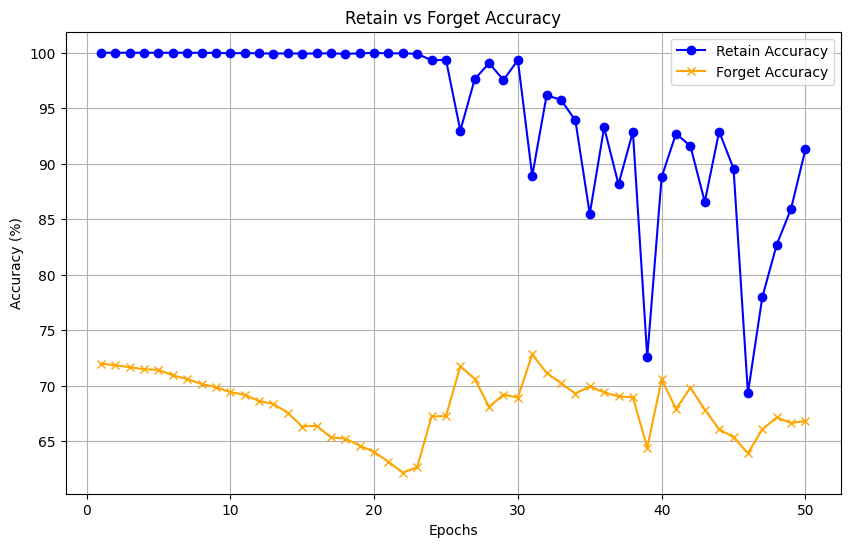

In [ ]:
import matplotlib.pyplot as plt

# Plot Retain vs Forget Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(retain_accuracies) + 1), retain_accuracies, label="Retain Accuracy", color="blue", marker="o")
plt.plot(range(1, len(forget_accuracies) + 1), forget_accuracies, label="Forget Accuracy", color="orange", marker="x")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Retain vs Forget Accuracy")
plt.legend()
plt.grid(True)
plt.show()


###Validation Accuracy Over Epochs
Shows the model's generalization capabilities and stability during training.

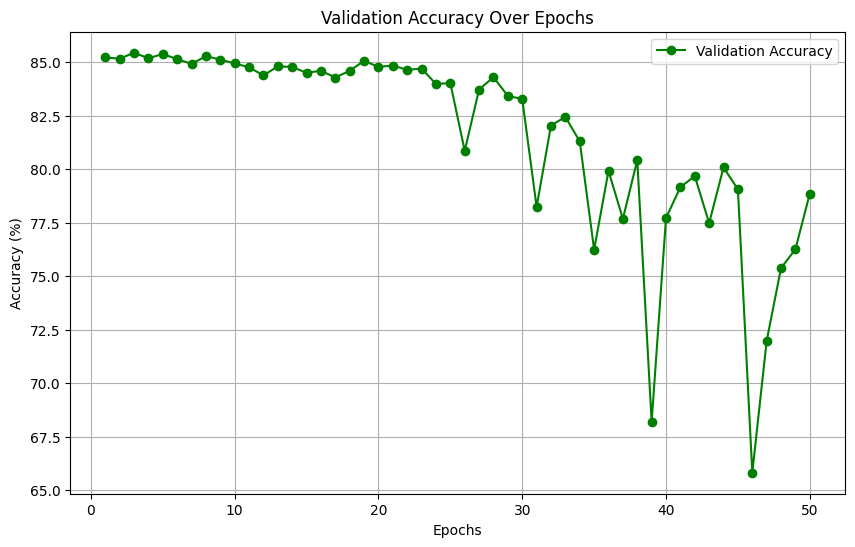

In [ ]:
# Plot Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label="Validation Accuracy", color="green", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


### Accuracy Gap (Retain - Forget)
Highlights the difference between retain and forget accuracies, indicating the model's ability to selectively unlearn.

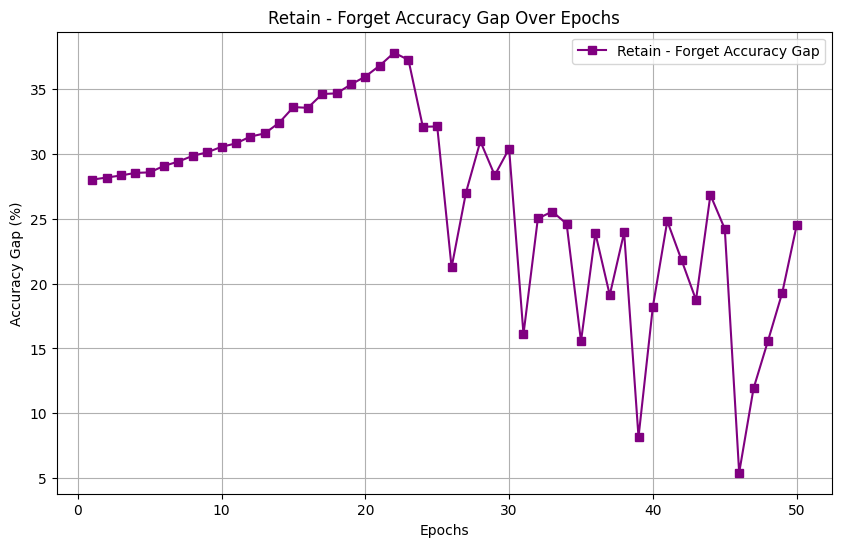

In [ ]:
# Calculate Accuracy Gap
accuracy_gap = [r - f for r, f in zip(retain_accuracies, forget_accuracies)]

# Plot Accuracy Gap
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracy_gap) + 1), accuracy_gap, label="Retain - Forget Accuracy Gap", color="purple", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Accuracy Gap (%)")
plt.title("Retain - Forget Accuracy Gap Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


### Reverse Scale Factor Over Epochs
Provides insight into how gradient reversal strength changes dynamically during training.

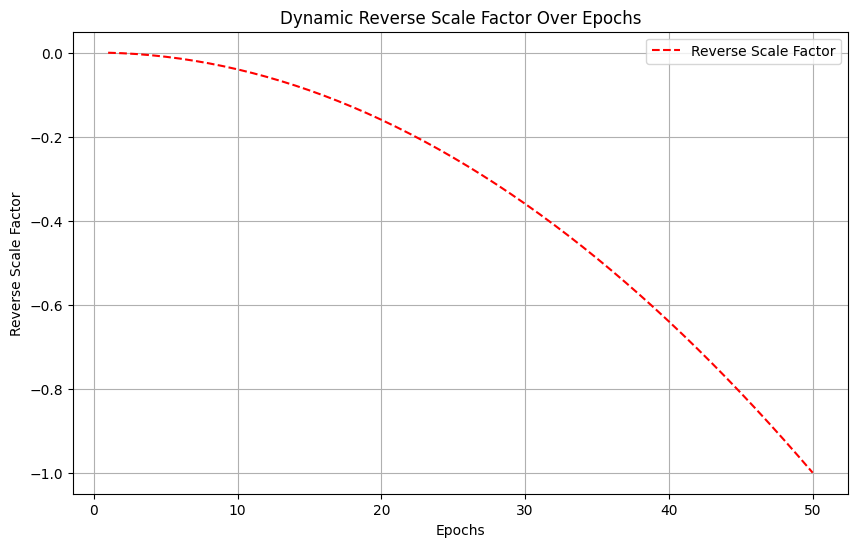

In [ ]:
# Calculate Reverse Scale Factors (assuming exponential scaling)
reverse_scales = [-1.0 * (epoch / 50) ** 2 for epoch in range(1, 51)]

# Plot Reverse Scale Factor
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(reverse_scales) + 1), reverse_scales, label="Reverse Scale Factor", color="red", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Reverse Scale Factor")
plt.title("Dynamic Reverse Scale Factor Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


###Retain Accuracy During Final Fine-Tuning
Demonstrates how fine-tuning improves the retain set accuracy, reinforcing the model's knowledge retention.

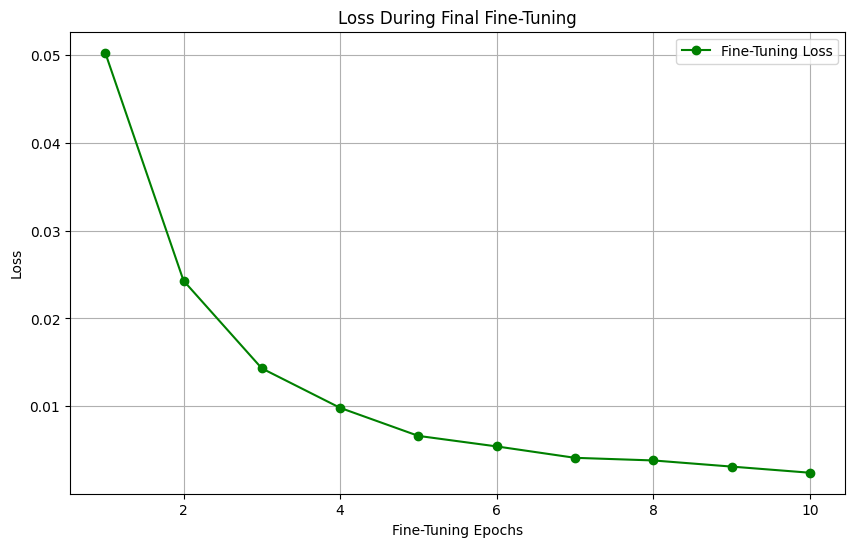

In [ ]:
# Example Loss During Fine-Tuning (replace with actual values)
fine_tune_losses = [0.0503, 0.0243, 0.0143, 0.0098, 0.0066, 0.0054, 0.0041, 0.0038, 0.0031, 0.0024]

# Plot Fine-Tuning Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(fine_tune_losses) + 1), fine_tune_losses, label="Fine-Tuning Loss", color="green", marker="o")
plt.xlabel("Fine-Tuning Epochs")
plt.ylabel("Loss")
plt.title("Loss During Final Fine-Tuning")
plt.legend()
plt.grid(True)
plt.show()


### Combined Insights
For a holistic overview, you can combine validation accuracy, retain accuracy, and forget accuracy in one plot.

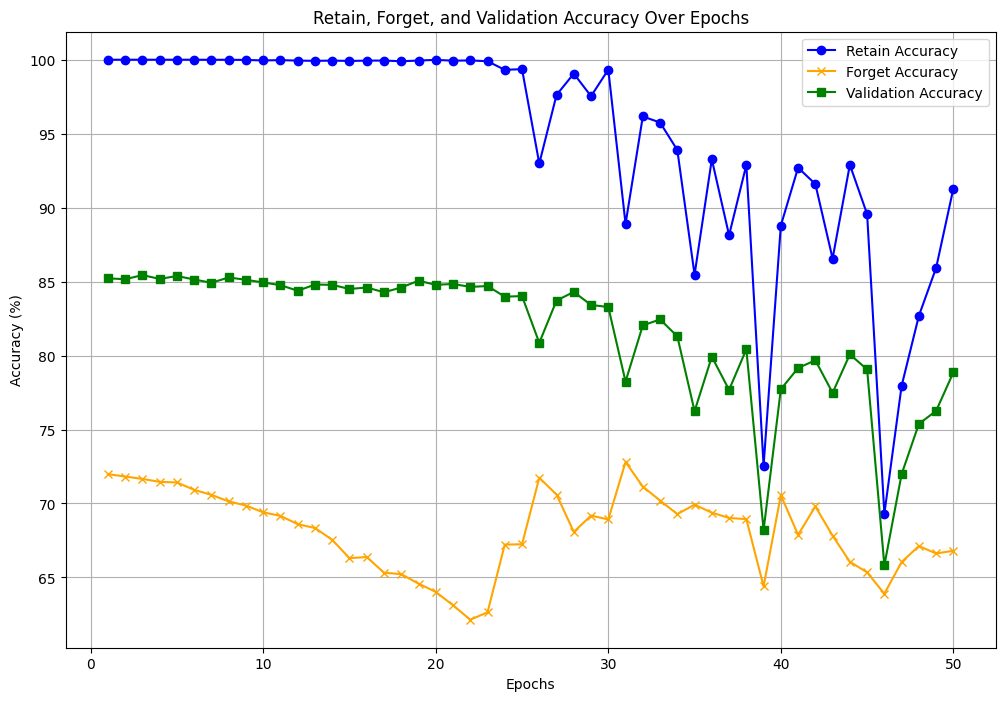

In [ ]:
# Plot Combined Metrics
plt.figure(figsize=(12, 8))
plt.plot(range(1, len(retain_accuracies) + 1), retain_accuracies, label="Retain Accuracy", color="blue", marker="o")
plt.plot(range(1, len(forget_accuracies) + 1), forget_accuracies, label="Forget Accuracy", color="orange", marker="x")
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label="Validation Accuracy", color="green", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Retain, Forget, and Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()
